In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

#from sklearn.impute import SimpleImputer

In [2]:
#Read the data using the Unnamed (probably id) as index
url = 'https://s3.amazonaws.com/drivendata/data/4/public/81e8f2de-9915-4934-b9ae-9705685c9d50.csv'
training = pd.read_csv(url, index_col='Unnamed: 0')

labels = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 
          'Sharing', 'Student_Type', 'Use']

numeric = ['FTE', 'Total']

categoric = [ 'Facility_or_Department', 'Function_Description', 
            'Fund_Description', 'Job_Title_Description', 'Location_Description', 
            'Object_Description', 'Position_Extra', 'Program_Description', 'SubFund_Description', 
            'Sub_Object_Description', 
            'Text_1', 'Text_2', 'Text_3', 'Text_4']

In [51]:
training.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,,...,,,1.000000,,,kindergarten,50471.810,kindergarten,general fund,
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,contractor services,...,,,0.750000,rgn gob,,undesignated,3477.860,building improvement services,,building improvement services
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,personal services - teachers,...,,,1.000000,,,teacher,62237.130,instruction - regular,general purpose school,
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,employee benefits,...,,,0.000000,unalloc budgets/schools,,professional-instructional,22.300,general middle/junior high sch,,regular instruction
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,teacher coverage for teacher,...,,,0.000059,non-project,,professional-instructional,54.166,general high school education,,regular instruction


## Pre-Processing

In [3]:
#Imputing data in Total column
def impute_func_total(data):
    if(pd.isnull(data['Total'])):        
        if(data['Object_Type'] == 'Base Salary/Compensation'):
            return 24146
        if(data['Object_Type'] == 'Benefits'):
            return 38163
        if(data['Object_Type'] == 'Contracted Services'):
            return 24146
        if(data['Object_Type'] == 'Equipment & Equipment Lease'):
            return 11257
        if(data['Object_Type'] == 'NO_LABEL'):
            return 58545
        if(data['Object_Type'] == 'Other Compensation/Stipend'):
            return 1605
        if(data['Object_Type'] == 'Other Non-Compensation'):
            return 10646
        if(data['Object_Type'] == 'Rent/Utilities'):
            return 46611
        if(data['Object_Type'] == 'Substitute Compensation'):
            return 1090
        if(data['Object_Type'] == 'Supplies/Materials'):
            return 7745
        if(data['Object_Type'] == 'Travel & Conferences'):
            return 1659
    else:
        return data['Total']

In [4]:
#Imputing data in FTE column
def impute_func_FTE(data):
    if(pd.isnull(data['FTE'])):        
        if(data['Object_Type'] == 'Base Salary/Compensation'):
            return 0.45
        if(data['Object_Type'] == 'Benefits'):
            return 0.0
        if(data['Object_Type'] == 'Contracted Services'):
            return 0.0
        if(data['Object_Type'] == 'Equipment & Equipment Lease'):
            return 0.0
        if(data['Object_Type'] == 'NO_LABEL'):
            return 0.75
        if(data['Object_Type'] == 'Other Compensation/Stipend'):
            return 0.000107
        if(data['Object_Type'] == 'Other Non-Compensation'):
            return 0.0
        if(data['Object_Type'] == 'Rent/Utilities'):
            return 0.0
        if(data['Object_Type'] == 'Substitute Compensation'):
            return 0.000059
        if(data['Object_Type'] == 'Supplies/Materials'):
            return 0.0
        if(data['Object_Type'] == 'Travel & Conferences'):
            return 0.0
    else:
        return data['FTE']

In [5]:
def preProcessing(training):
    # Remove inconsistent data
    training.loc[training['FTE'] < 0, 'FTE'] = np.nan
    training.loc[training['Total'] < 0, 'Total'] = np.nan
    
    training['Total'] = training.apply(impute_func_total, axis = 1)
    
    #Put FET data greater than 1 in percentage 
    mask = training['FTE'] > 1
    df_ToAtt = training[mask]
    training.loc[mask, 'FTE'] = df_ToAtt['FTE'].div(100)
    
    training['FTE'] = training.apply(impute_func_FTE, axis = 1)
    
    for category in categoric:
        training[category] = training[category].str.lower()
    
    training[categoric] = training[categoric].fillna("")
    
    return training

In [6]:
df_training = preProcessing(training)
df_training = df_training.reset_index(drop = True)

## Test ANN - scikt

In [75]:
#from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.neural_network import MLPClassifier

In [8]:
target = pd.get_dummies(df_training[['Object_Type']])
train = df_training[categoric]

In [81]:
#X_train, X_test, y_train, y_test = train_test_split(df_training,
#                                                    pd.get_dummies(df_training[['Object_Type']]),
#                                                    test_size=0.2, 
#                                                    random_state=42)

In [9]:
def combine_text_columns(dataset):
    return dataset[categoric].apply(lambda x: " ".join(x), axis = 1)

In [10]:
get_text_data = FunctionTransformer(combine_text_columns, validate = False)

In [11]:
stop_words = ['a', 'e', 'i', 'o', 'u', 'to', 'all', 'of', 'for', 'and', 'or', 'b', 'with', 'not', 'than', 'other', 'top', 's', 'k', 'in', 'the']
vec = CountVectorizer(token_pattern="[A-Za-z0-9]+(?=\\s+)", ngram_range=(1,2), stop_words = stop_words)

In [57]:
# Adding the input layer and the first hidden, the hidden layer number is (11)/2
mlp = MLPClassifier(hidden_layer_sizes=(20,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=True, tol=1e-4, random_state=42, momentum = 0.8, 
                    validation_fraction = 0.3, early_stopping = True, n_iter_no_change = 10,
                    learning_rate_init=.1)

In [58]:
# Edit model step in pipeline
pl = Pipeline([
        ('selector', get_text_data),
        ('vectorizer', vec),
        #('reduce_dim', TruncatedSVD(n_iter=7, n_components = 1000)),
        #('reduce_dim', NMF(n_components = 200)),
        ('reduce_dim', SelectKBest(chi2, 1000)),
        ('mlp', mlp)
    ])

In [59]:
#cross_val_score(pl, train, target, cv=2)
y_pred = cross_val_predict(pl, train, target, cv=5)

Iteration 1, loss = 0.42501170
Validation score: 0.951482
Iteration 2, loss = 0.20752908
Validation score: 0.959070
Iteration 3, loss = 0.18326212
Validation score: 0.965847
Iteration 4, loss = 0.17106608
Validation score: 0.964129
Iteration 5, loss = 0.16153529
Validation score: 0.964546
Iteration 6, loss = 0.15530490
Validation score: 0.968980
Iteration 7, loss = 0.15051297
Validation score: 0.967606
Iteration 8, loss = 0.14607191
Validation score: 0.969854
Iteration 9, loss = 0.14274729
Validation score: 0.970916
Iteration 10, loss = 0.13933510
Validation score: 0.971520
Iteration 11, loss = 0.13684196
Validation score: 0.970604
Iteration 12, loss = 0.13471490
Validation score: 0.970177
Iteration 13, loss = 0.13277444
Validation score: 0.972863
Iteration 14, loss = 0.13050514
Validation score: 0.970729
Iteration 15, loss = 0.12896812
Validation score: 0.973310
Iteration 16, loss = 0.12796124
Validation score: 0.971020
Iteration 17, loss = 0.12648057
Validation score: 0.973019
Iterat

Validation score: 0.976756
Iteration 41, loss = 0.10981905
Validation score: 0.975725
Iteration 42, loss = 0.10983566
Validation score: 0.975704
Iteration 43, loss = 0.10925311
Validation score: 0.976673
Iteration 44, loss = 0.10881226
Validation score: 0.976870
Iteration 45, loss = 0.10840646
Validation score: 0.976204
Iteration 46, loss = 0.10827301
Validation score: 0.976371
Iteration 47, loss = 0.10815540
Validation score: 0.975465
Iteration 48, loss = 0.10783140
Validation score: 0.975257
Iteration 49, loss = 0.10782671
Validation score: 0.975288
Iteration 50, loss = 0.10719752
Validation score: 0.976048
Iteration 51, loss = 0.10710786
Validation score: 0.976371
Iteration 52, loss = 0.10664966
Validation score: 0.974653
Iteration 53, loss = 0.10681124
Validation score: 0.975757
Iteration 54, loss = 0.10652775
Validation score: 0.976142
Iteration 55, loss = 0.10594973
Validation score: 0.976860
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopp

In [61]:
y_pred.shape

(400277, 11)

In [107]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #fig, ax = plt.subplots(figsize=(20, 10))
    plt.figure(figsize=(10,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
#Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
#Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
#Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix

In [91]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400277 entries, 0 to 400276
Data columns (total 11 columns):
Object_Type_Base Salary/Compensation       400277 non-null uint8
Object_Type_Benefits                       400277 non-null uint8
Object_Type_Contracted Services            400277 non-null uint8
Object_Type_Equipment & Equipment Lease    400277 non-null uint8
Object_Type_NO_LABEL                       400277 non-null uint8
Object_Type_Other Compensation/Stipend     400277 non-null uint8
Object_Type_Other Non-Compensation         400277 non-null uint8
Object_Type_Rent/Utilities                 400277 non-null uint8
Object_Type_Substitute Compensation        400277 non-null uint8
Object_Type_Supplies/Materials             400277 non-null uint8
Object_Type_Travel & Conferences           400277 non-null uint8
dtypes: uint8(11)
memory usage: 4.2 MB


In [79]:
confusion_mtx = confusion_matrix(target.values.argmax(axis=1), y_pred.argmax(axis=1)) 

In [92]:
classes = ["Base Salary/Compensation", "Benefits", "Contracted Services", "Equipment & Equipment Lease", "NO_LABEL", 
          "Other Compensation/Stipend", "Other Non-Compensation", "Rent/Utilities", "Substitute Compensation", 
          "Supplies/Materials", "Travel & Conferences"]

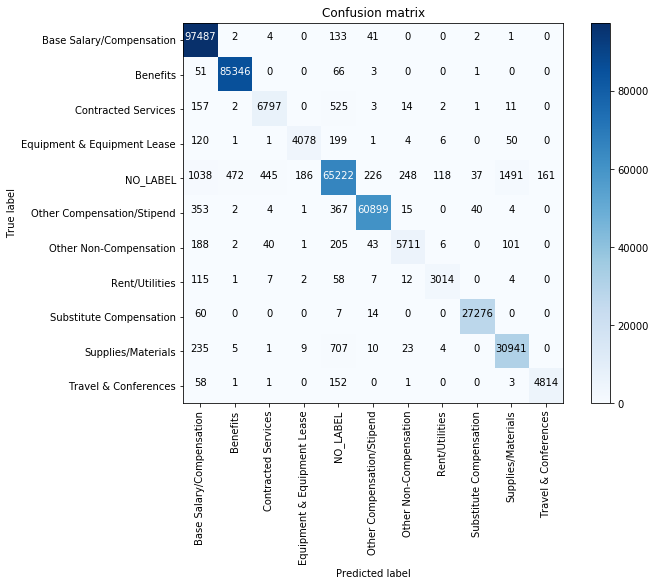

In [108]:
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = classes)

In [71]:
target.values.argmax(axis=1)

array([4, 4, 0, ..., 4, 1, 8])

In [69]:
y_pred.argmax(axis=1)

array([4, 4, 0, ..., 4, 1, 8])

In [73]:
confusion_mtx = confusion_matrix(target.values.argmax(axis=1), y_pred.argmax(axis=1)) 

In [67]:
confusion_mtx

array([[97487,     2,     4,     0,   133,    41,     0,     0,     2,
            1,     0],
       [   51, 85346,     0,     0,    66,     3,     0,     0,     1,
            0,     0],
       [  157,     2,  6797,     0,   525,     3,    14,     2,     1,
           11,     0],
       [  120,     1,     1,  4078,   199,     1,     4,     6,     0,
           50,     0],
       [ 1038,   472,   445,   186, 65222,   226,   248,   118,    37,
         1491,   161],
       [  353,     2,     4,     1,   367, 60899,    15,     0,    40,
            4,     0],
       [  188,     2,    40,     1,   205,    43,  5711,     6,     0,
          101,     0],
       [  115,     1,     7,     2,    58,     7,    12,  3014,     0,
            4,     0],
       [   60,     0,     0,     0,     7,    14,     0,     0, 27276,
            0,     0],
       [  235,     5,     1,     9,   707,    10,    23,     4,     0,
        30941,     0],
       [   58,     1,     1,     0,   152,     0,     1,    

In [88]:
pl.fit(X_train, y_train)

Iteration 1, loss = 0.35380192
Iteration 2, loss = 0.20477527
Iteration 3, loss = 0.18940700
Iteration 4, loss = 0.18044772
Iteration 5, loss = 0.17466003
Iteration 6, loss = 0.17118200
Iteration 7, loss = 0.16791081
Iteration 8, loss = 0.16551874
Iteration 9, loss = 0.16316978
Iteration 10, loss = 0.16149769
Iteration 11, loss = 0.15929852
Iteration 12, loss = 0.15735634
Iteration 13, loss = 0.15584755
Iteration 14, loss = 0.15373227
Iteration 15, loss = 0.15171364
Iteration 16, loss = 0.15082620
Iteration 17, loss = 0.14933508
Iteration 18, loss = 0.14833810
Iteration 19, loss = 0.14747446
Iteration 20, loss = 0.14673784
Iteration 21, loss = 0.14592348
Iteration 22, loss = 0.14557281
Iteration 23, loss = 0.14419495
Iteration 24, loss = 0.14332894
Iteration 25, loss = 0.14224476
Iteration 26, loss = 0.14208719
Iteration 27, loss = 0.14165525
Iteration 28, loss = 0.14102802
Iteration 29, loss = 0.14085701
Iteration 30, loss = 0.13938749
Iteration 31, loss = 0.13998534
Iteration 32, los

/home/danielmarx/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function combine_text_columns at 0x7f3b2e250840>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False)), ('vectorizer', CountVectorizer(analyzer='wo...ffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=10, warm_start=False))])

In [89]:
from sklearn.metrics import accuracy_score

y_pred = pl.predict(X_test)
accuracy_score(y_test.values, y_pred, normalize=True)

0.9697586689317478

In [94]:
df_training.head(1)

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
0,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,,...,,,1.0,,,kindergarten,50471.81,kindergarten,general fund,


In [90]:
y_pred

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [92]:
y_test.values

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)